# Ранжирование данных

**Цель исследования:** натренировать на любом удобном фреймворке модель, которая будет ранжировать документы по их признакам внутри одной сессии (query_id) (по вектору фичей предсказывать ранк документа).

**Задачи исследования:**

1. Подготовить и проверить датасет.

2. Посчитать метрики ранжирования модели (ndcg_5 как минимум).

Данные получим из датасета `intern_task.csv`.

**Описание данных:**

- query_id — айди поисковой сессии
- признаки релевантности документа запросу
- rank — оценка релевантности.

## Подготовка данных

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRanker, Pool, MetricVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

from collections import Counter

from copy import deepcopy

import shap

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 29042024

### Прочитаем датасет и посмотрим основную информацию

In [2]:
df = pd.read_csv('intern_task.csv')
df.shape # размер исходной таблицы (строки, столбцы)

(235258, 146)

In [3]:
df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235258 entries, 0 to 235257
Columns: 146 entries, rank to feature_143
dtypes: float64(140), int64(6)
memory usage: 262.1 MB


In [5]:
df.describe()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


**Проверим количество пропусков**

In [6]:
print("Количество пропусков:", df.isnull().sum().sum())

Количество пропусков: 0


**Проверим количество дубликатов**

In [7]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


### Рассмотрим данные столбцов `rank` и `query_id`

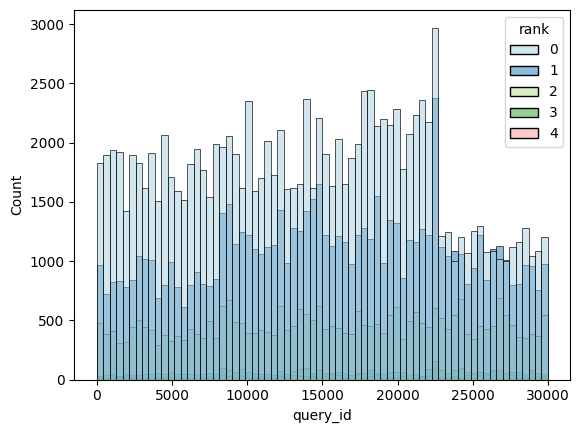

In [8]:
hist = sns.histplot(df, x="query_id", hue="rank", palette="Paired")
plt.show()

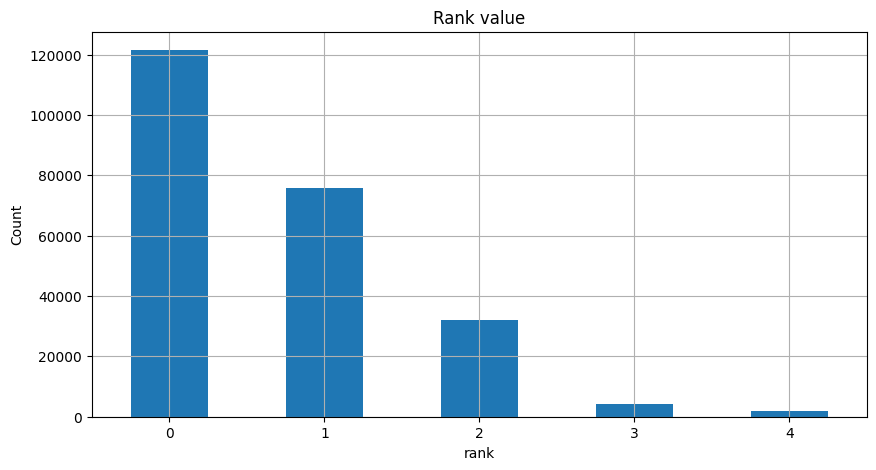

In [9]:
rank = df.groupby('rank')['rank'].count().plot(
    x='rank',
    kind='bar',
    figsize=(10, 5),
    grid=True,
    title = 'Rank value'
)
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [10]:
df['rank'].value_counts()

rank
0    121521
1     75815
2     31910
3      4209
4      1803
Name: count, dtype: int64

In [11]:
df['rank'].value_counts(normalize=True)

rank
0    0.516544
1    0.322263
2    0.135638
3    0.017891
4    0.007664
Name: proportion, dtype: float64

In [12]:
df['query_id'].value_counts().sort_values(ascending=False)

query_id
22540    908
13930    773
22450    522
19945    444
9940     430
        ... 
22780      2
14350      2
9265       1
20560      1
28285      1
Name: count, Length: 2000, dtype: int64

In [13]:
df['query_id'].nunique()

2000

**Вывод:** 

- В исходных данных 235258 строк и 146 столбцов.
- Пропусков и дубликатов нет.
- Большая часть поисковых сессий имеет нулевую (0) оценку релевантности (51.7%) и всего 0.8% - оценку 4. 
- В датасете представлено 2000 уникальных значений поисковых сессий `query_id`.

## Подготовка данных для построения модели

**Разделим датасет df на тренировочную (*train_df*) и тестовую (*test_df*) выборки в соотношении 80:20 и перемешаем данные**

In [14]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print('Размер train_df:', train_df.shape)
print('Размер test_df:', test_df.shape)

Размер train_df: (188206, 146)
Размер test_df: (47052, 146)


In [15]:
train_df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
32604,0,4480,2.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,...,0.0,0.000000,0.000000,0.642737,15.029216,0.0,0.036184,0.000608,9.0,4.500000
201089,2,24400,4.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,...,1.0,3.800000,0.000000,0.895074,0.000000,0.0,0.019424,0.000213,147.0,36.750000
216225,0,26815,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,9.0,34.006667,0.000000,0.981198,0.000000,0.0,0.004337,0.000001,7.0,2.333333
151951,0,18790,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,7.0,37.900000,0.000000,0.978216,0.000000,0.0,0.001928,0.000000,3.0,1.500000
125081,1,15820,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.000000,0.142857,1.000000,9.749336,1.0,0.013640,0.000000,14.0,14.000000


**Сгруппируем данные по *query_id* (это необходимо для функции Pool)**

In [16]:
train_df = train_df.sort_values(by=['query_id']).reset_index(drop=True)
test_df = test_df.sort_values(by=['query_id']).reset_index(drop=True)

train_df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,0.0,0.0,0.250000,0.996441,18.240926,0.333333,0.019916,0.000007,15.0,5.000000
1,0,10,1.0,0.0,0.0,0.0,1.0,0.333333,0.0,0.000000,...,0.0,0.0,0.000000,0.890238,0.000000,0.000000,0.008230,0.000162,2.0,0.666667
2,0,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,0.0,0.0,0.142857,0.975755,18.240926,0.333333,0.023725,0.000062,16.0,5.333333
3,1,10,2.0,0.0,2.0,1.0,2.0,0.666667,0.0,0.666667,...,0.0,0.0,0.166667,0.907969,13.545122,0.333333,0.019259,0.000180,10.0,3.333333
4,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.0,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667


**Разделим наши выборки на 3 отдельные таблицы: признаки (*X*), айдишники (*queries*) и целевой признак ранжирования (*y*)**

In [17]:
X_train = train_df.drop(columns=['rank', 'query_id'], axis=1)
y_train = train_df['rank']
queries_train = train_df['query_id']

X_test = test_df.drop(columns=['rank', 'query_id'], axis=1)
y_test = test_df['rank']
queries_test = test_df['query_id']

print('Размер X_train:', X_train.shape)
print('Размер X_test:', X_test.shape)
print('Размер queries_train:', queries_train.shape)
print('Размер queries_test:', queries_test.shape)
print('Размер y_train:', y_train.shape)
print('Размер y_test:', y_test.shape)

Размер X_train: (188206, 144)
Размер X_test: (47052, 144)
Размер queries_train: (188206,)
Размер queries_test: (47052,)
Размер y_train: (188206,)
Размер y_test: (47052,)


In [18]:
X_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,0.199782,1.000000,...,0.0,0.0,0.250000,0.996441,18.240926,0.333333,0.019916,0.000007,15.0,5.000000
1,1.0,0.0,0.0,0.0,1.0,0.333333,0.0,0.000000,0.072261,0.333333,...,0.0,0.0,0.000000,0.890238,0.000000,0.000000,0.008230,0.000162,2.0,0.666667
2,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,0.293296,1.000000,...,0.0,0.0,0.142857,0.975755,18.240926,0.333333,0.023725,0.000062,16.0,5.333333
3,2.0,0.0,2.0,1.0,2.0,0.666667,0.0,0.666667,0.378310,0.666667,...,0.0,0.0,0.166667,0.907969,13.545122,0.333333,0.019259,0.000180,10.0,3.333333
4,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,0.012752,1.000000,...,0.0,0.0,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667


In [19]:
queries_train.head()

0    10
1    10
2    10
3    10
4    10
Name: query_id, dtype: int64

In [20]:
y_train.head()

0    2
1    0
2    0
3    1
4    1
Name: rank, dtype: int64

**Посмотрим статистику меток релевантности целевого признака *rank***

In [21]:
Counter(y_train).items()

dict_items([(2, 25539), (0, 97242), (1, 60613), (4, 1445), (3, 3367)])

**Для расчета метрик релевантности NDCG и PFound, данные должны находиться в отрезке [0, 1].**

In [22]:
max_relevance = np.max(y_train)

y_train /= max_relevance
y_test /= max_relevance

In [23]:
y_train.head()

0    0.50
1    0.00
2    0.00
3    0.25
4    0.25
Name: rank, dtype: float64

**Число уникальных айдишников**

In [24]:
num_queries = np.unique(queries_train).shape[0]
num_queries

1999

**Создаем *CatBoost pools***

In [25]:
train = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test
)

## Обучение модели

**Зададим параметры для нашей модели** 

Метриками оценки будут 

- `Normalized discounted cumulative gain (nDCG)`
- `PFound`
- `AverageGain`

In [26]:
default_parameters = {
    'iterations': 4000,
    'custom_metric': ['NDCG:top=5', 'PFound', 'AverageGain:top=10'],
    'verbose': 500,
    'random_seed': 0,
}

parameters = {}

In [27]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool)

    return model

### Простейшая модель RMSE

In [28]:
%%time
rmse_model = fit_model('RMSE', {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10', 'NDCG:top=5']})

Learning rate set to 0.049746
0:	learn: 0.2064436	test: 0.2062011	best: 0.2062011 (0)	total: 189ms	remaining: 12m 36s
500:	learn: 0.1818433	test: 0.1836981	best: 0.1836981 (500)	total: 23.7s	remaining: 2m 45s
1000:	learn: 0.1772480	test: 0.1813262	best: 0.1813262 (1000)	total: 47s	remaining: 2m 20s
1500:	learn: 0.1739026	test: 0.1799212	best: 0.1799212 (1500)	total: 1m 10s	remaining: 1m 57s
2000:	learn: 0.1710878	test: 0.1789036	best: 0.1789036 (2000)	total: 1m 33s	remaining: 1m 33s
2500:	learn: 0.1685701	test: 0.1781985	best: 0.1781985 (2500)	total: 1m 58s	remaining: 1m 11s
3000:	learn: 0.1663630	test: 0.1776707	best: 0.1776707 (3000)	total: 2m 22s	remaining: 47.3s
3500:	learn: 0.1643291	test: 0.1772575	best: 0.1772575 (3500)	total: 2m 45s	remaining: 23.6s
3999:	learn: 0.1624568	test: 0.1768939	best: 0.1768936 (3997)	total: 3m 9s	remaining: 0us

bestTest = 0.1768936399
bestIteration = 3997

Shrink model to first 3998 iterations.
CPU times: total: 27min 42s
Wall time: 3min 10s


In [29]:
best_score_rmse = rmse_model.best_score_
pd.DataFrame(best_score_rmse)

,learn,validation
MAP:top=10,0.279926,0.164527
RecallAt:top=10,0.773744,0.923654
PrecisionAt:top=10,0.137419,0.045917
RMSE,0.162457,0.176894
NDCG:top=5;type=Base,NaN,0.652809


### Параметр групповых весов

Предположим, что одни запросы для нас важнее других. Слово «важность» используется здесь с точки зрения точности или качества прогноза *CatBoostRanker* для данных запросов.
Передадим эту дополнительную информацию,ииспользуя параметр `group_weights`. Под капотом *CatBoostRanker* использует эти веса в функции потерь, просто умножая их на групповое слагаемое.
Поэтому чем больше вес, тем больше внимания к запросу.

In [30]:
def create_weights(queries):
    query_set = np.unique(queries)
    query_weights = np.random.uniform(size=query_set.shape[0])
    weights = np.zeros(shape=queries.shape)

    for i, query_id in enumerate(query_set):
        weights[queries == query_id] = query_weights[i]

    return weights


train_with_weights = Pool(
    data=X_train,
    label=y_train,
    group_weight=create_weights(queries_train),
    group_id=queries_train
)

test_with_weights = Pool(
    data=X_test,
    label=y_test,
    group_weight=create_weights(queries_test),
    group_id=queries_test
)

In [31]:
%%time
rmse_model_weight = fit_model(
    'RMSE',
    additional_params={'train_dir': 'RMSE_weigths'},
    train_pool=train_with_weights,
    test_pool=test_with_weights
)

Learning rate set to 0.049746
0:	learn: 0.2060094	test: 0.2060354	best: 0.2060354 (0)	total: 37.3ms	remaining: 2m 29s
500:	learn: 0.1803448	test: 0.1841458	best: 0.1841458 (500)	total: 16.4s	remaining: 1m 54s
1000:	learn: 0.1751716	test: 0.1822686	best: 0.1822686 (1000)	total: 32.8s	remaining: 1m 38s
1500:	learn: 0.1713163	test: 0.1812959	best: 0.1812959 (1500)	total: 49.3s	remaining: 1m 22s
2000:	learn: 0.1680402	test: 0.1805714	best: 0.1805714 (2000)	total: 1m 5s	remaining: 1m 5s
2500:	learn: 0.1651093	test: 0.1799792	best: 0.1799792 (2500)	total: 1m 22s	remaining: 49.4s
3000:	learn: 0.1624059	test: 0.1795188	best: 0.1795188 (3000)	total: 1m 38s	remaining: 32.9s
3500:	learn: 0.1599657	test: 0.1791724	best: 0.1791724 (3500)	total: 1m 55s	remaining: 16.5s
3999:	learn: 0.1577249	test: 0.1789487	best: 0.1789480 (3989)	total: 2m 11s	remaining: 0us

bestTest = 0.1789479634
bestIteration = 3989

Shrink model to first 3990 iterations.
CPU times: total: 26min 34s
Wall time: 2min 13s


In [32]:
best_score_rmse_weight = rmse_model_weight.best_score_
pd.DataFrame(best_score_rmse_weight)

,learn,validation
AverageGain:top=10,0.375712,0.209736
RMSE,0.157725,0.178948
PFound,NaN,0.634434
NDCG:top=5;type=Base,NaN,0.641791


### QueryRMSE

Введем в RMSE коэффициент, который зависит только от запроса (и если факт равен среднему значению разницы между прогнозом и рангом).

In [33]:
%%time
query_rmse_model = fit_model('QueryRMSE')

0:	learn: 0.1908844	test: 0.1878346	best: 0.1878346 (0)	total: 38.5ms	remaining: 2m 34s
500:	learn: 0.1779855	test: 0.1765514	best: 0.1765514 (500)	total: 18.7s	remaining: 2m 10s
1000:	learn: 0.1751197	test: 0.1751572	best: 0.1751572 (1000)	total: 37.2s	remaining: 1m 51s
1500:	learn: 0.1730604	test: 0.1744444	best: 0.1744444 (1500)	total: 55.8s	remaining: 1m 32s
2000:	learn: 0.1712414	test: 0.1738550	best: 0.1738550 (2000)	total: 1m 14s	remaining: 1m 13s
2500:	learn: 0.1695594	test: 0.1733650	best: 0.1733650 (2500)	total: 1m 32s	remaining: 55.4s
3000:	learn: 0.1681003	test: 0.1730379	best: 0.1730379 (3000)	total: 1m 50s	remaining: 36.9s
3500:	learn: 0.1667198	test: 0.1727497	best: 0.1727491 (3498)	total: 2m 9s	remaining: 18.4s
3999:	learn: 0.1654626	test: 0.1725073	best: 0.1725073 (3999)	total: 2m 27s	remaining: 0us

bestTest = 0.1725073093
bestIteration = 3999

CPU times: total: 28min 12s
Wall time: 2min 28s


In [34]:
best_score_query_rmse = query_rmse_model.best_score_
pd.DataFrame(best_score_query_rmse)

,learn,validation
AverageGain:top=10,0.343533,0.210920
QueryRMSE,0.165463,0.172507
PFound,NaN,0.636553
NDCG:top=5;type=Base,NaN,0.647060


### PairLogit

Метод, основанный на парных сравнениях

In [35]:
%%time
pl_model = fit_model('PairLogit', {'metric_period': 50, 'task_type': 'GPU'})

Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6908331	test: 0.6908724	best: 0.6908724 (0)	total: 167ms	remaining: 11m 7s
500:	learn: 0.5969590	test: 0.6166205	best: 0.6166205 (500)	total: 15.1s	remaining: 1m 45s
1000:	learn: 0.5720387	test: 0.6086227	best: 0.6086227 (1000)	total: 30s	remaining: 1m 29s
1500:	learn: 0.5528084	test: 0.6039325	best: 0.6039325 (1500)	total: 44.8s	remaining: 1m 14s
2000:	learn: 0.5364929	test: 0.6011105	best: 0.6011105 (2000)	total: 59.5s	remaining: 59.5s
2500:	learn: 0.5219114	test: 0.5986762	best: 0.5986762 (2500)	total: 1m 14s	remaining: 44.5s
3000:	learn: 0.5086689	test: 0.5971412	best: 0.5971412 (3000)	total: 1m 29s	remaining: 29.6s
3500:	learn: 0.4963547	test: 0.5956990	best: 0.5956990 (3500)	total: 1m 43s	remaining: 14.8s
3999:	learn: 0.4853240	test: 0.5943276	best: 0.5943276 (3999)	total: 1m 58s	remaining: 0us
bestTest = 0.5943276346
bestIteration = 3999
CPU times: total: 3min 54s
Wall time: 1min 59s


In [36]:
pl_best = pl_model.best_score_
pd.DataFrame(pl_best)

,learn,validation
AverageGain:top=10,0.334028,0.211715
PairLogit,0.485324,0.594328
PFound,NaN,0.634972
NDCG:top=5;type=Base,NaN,0.644111


### PairLogitPairwise

Эта метрика может давать более точные результаты на больших наборах данных по сравнению с *PairLogit*

In [37]:
%%time
plp_model = fit_model('PairLogitPairwise', {'metric_period': 50, 'task_type': 'GPU'})

Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6908797	test: 0.6909387	best: 0.6909387 (0)	total: 228ms	remaining: 15m 10s
500:	learn: 0.6000721	test: 0.6161676	best: 0.6161676 (500)	total: 47.9s	remaining: 5m 34s
1000:	learn: 0.5774428	test: 0.6076342	best: 0.6076342 (1000)	total: 1m 34s	remaining: 4m 44s
1500:	learn: 0.5604972	test: 0.6029949	best: 0.6029949 (1500)	total: 2m 21s	remaining: 3m 55s
2000:	learn: 0.5453927	test: 0.5994161	best: 0.5994161 (2000)	total: 3m 8s	remaining: 3m 8s
2500:	learn: 0.5322912	test: 0.5967875	best: 0.5967875 (2500)	total: 3m 55s	remaining: 2m 21s
3000:	learn: 0.5201577	test: 0.5946717	best: 0.5946717 (3000)	total: 4m 43s	remaining: 1m 34s
3500:	learn: 0.5090835	test: 0.5930626	best: 0.5930626 (3500)	total: 5m 30s	remaining: 47.1s
3999:	learn: 0.4989621	test: 0.5921480	best: 0.5921480 (3999)	total: 6m 16s	remaining: 0us
bestTest = 0.5921480185
bestIteration = 3999
CPU times: total: 12min 35s
Wall time: 6min 17s


In [38]:
plp_best = plp_model.best_score_
pd.DataFrame(plp_best)

,learn,validation
AverageGain:top=10,0.329013,0.211033
PairLogit,0.498962,0.592148
PFound,NaN,0.635467
NDCG:top=5;type=Base,NaN,0.642724


### YetiRank

Позволяет использовать показатели ранжирования для оптимизации. Метод генерирует веса для пар в соответствии с их позициями.

In [39]:
%%time
yr_model = fit_model('YetiRank', {'metric_period': 50, 'task_type': 'GPU', 'train_dir': 'YetiRank-lr-0.3', 'learning_rate': 0.3})

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4896437	best: 0.4896437 (0)	total: 19.1ms	remaining: 1m 16s
500:	test: 0.6284266	best: 0.6284266 (500)	total: 4.59s	remaining: 32.1s
1000:	test: 0.6323407	best: 0.6323407 (1000)	total: 9.15s	remaining: 27.4s
1500:	test: 0.6341797	best: 0.6341797 (1500)	total: 13.7s	remaining: 22.8s
2000:	test: 0.6364129	best: 0.6364129 (2000)	total: 18.3s	remaining: 18.3s
2500:	test: 0.6374609	best: 0.6375387 (2450)	total: 22.9s	remaining: 13.7s
3000:	test: 0.6380306	best: 0.6381222 (2900)	total: 27.4s	remaining: 9.12s
3500:	test: 0.6383516	best: 0.6383516 (3500)	total: 31.9s	remaining: 4.55s
3999:	test: 0.6387266	best: 0.6390138 (3900)	total: 36.4s	remaining: 0us
bestTest = 0.6390138381
bestIteration = 3900
Shrink model to first 3901 iterations.
CPU times: total: 1min 10s
Wall time: 37 s


In [40]:
yr_best = yr_model.best_score_
pd.DataFrame(yr_best)

,learn,validation
AverageGain:top=10,0.377462,0.210339
PFound,NaN,0.639014
NDCG:top=5;type=Base,NaN,0.651912


### YetiRankPairwise

In [41]:
%%time
yrp_model = fit_model('YetiRankPairwise', {'metric_period': 50, 'task_type': 'GPU', 'train_dir': 'YetiRank-lr-0.3', 'learning_rate': 0.3})

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5100393	best: 0.5100393 (0)	total: 39.8ms	remaining: 2m 39s
500:	test: 0.6259830	best: 0.6259830 (500)	total: 14.6s	remaining: 1m 42s
1000:	test: 0.6282808	best: 0.6282808 (1000)	total: 29.1s	remaining: 1m 27s
1500:	test: 0.6293416	best: 0.6296521 (1250)	total: 43.6s	remaining: 1m 12s
2000:	test: 0.6310751	best: 0.6310751 (2000)	total: 58.2s	remaining: 58.2s
2500:	test: 0.6312287	best: 0.6315991 (2450)	total: 1m 12s	remaining: 43.7s
3000:	test: 0.6320751	best: 0.6321254 (2850)	total: 1m 27s	remaining: 29.2s
3500:	test: 0.6323781	best: 0.6326876 (3300)	total: 1m 42s	remaining: 14.6s
3999:	test: 0.6330904	best: 0.6330904 (3999)	total: 1m 57s	remaining: 0us
bestTest = 0.6330904434
bestIteration = 3999
CPU times: total: 3min 55s
Wall time: 1min 57s


In [42]:
yrp_best = yrp_model.best_score_
pd.DataFrame(yrp_best)

,learn,validation
AverageGain:top=10,0.357027,0.209479
PFound,NaN,0.633090
NDCG:top=5;type=Base,NaN,0.641009


In [43]:
models = [rmse_model, rmse_model_weight, query_rmse_model, pl_model, plp_model, yr_model, yrp_model]
losses = ['RMSE', 'Weight+RMSE', 'QueryRMSE', 'PairLogit', 'PairLogitPairwise', 'YetiRank', 'YetiRankPairwise']

In [44]:
def get_ndcg():
    ndcg_scores = []
    for model in models:
        
        y_pred = model.predict(X_test)
        ndcg_scores.append(ndcg_score([y_test], [y_pred], k=5))
        
    return ndcg_scores

ndcg_scores = get_ndcg()

In [48]:
total_ndsg_table = {loss: ndcg for loss, ndcg in zip(losses, list(ndcg_scores))}
total_ndsg_table
for key, value in total_ndsg_table.items():
    print(key, value)

RMSE 0.9999999999999999
Weight+RMSE 0.9999999999999999
QueryRMSE 0.9999999999999999
PairLogit 0.9999999999999999
PairLogitPairwise 0.865079104405067
YetiRank 0.9999999999999999
YetiRankPairwise 0.9210878868801213


Видим странные значения в 0.99, возможно модель переобучилась. Требуется дополнительная проверка.

**Посмотрим важность признаков для модели RMSE**

In [46]:
explainer = shap.Explainer(rmse_model, feature_names=X_train.columns)
shap_values = explainer(X_train)

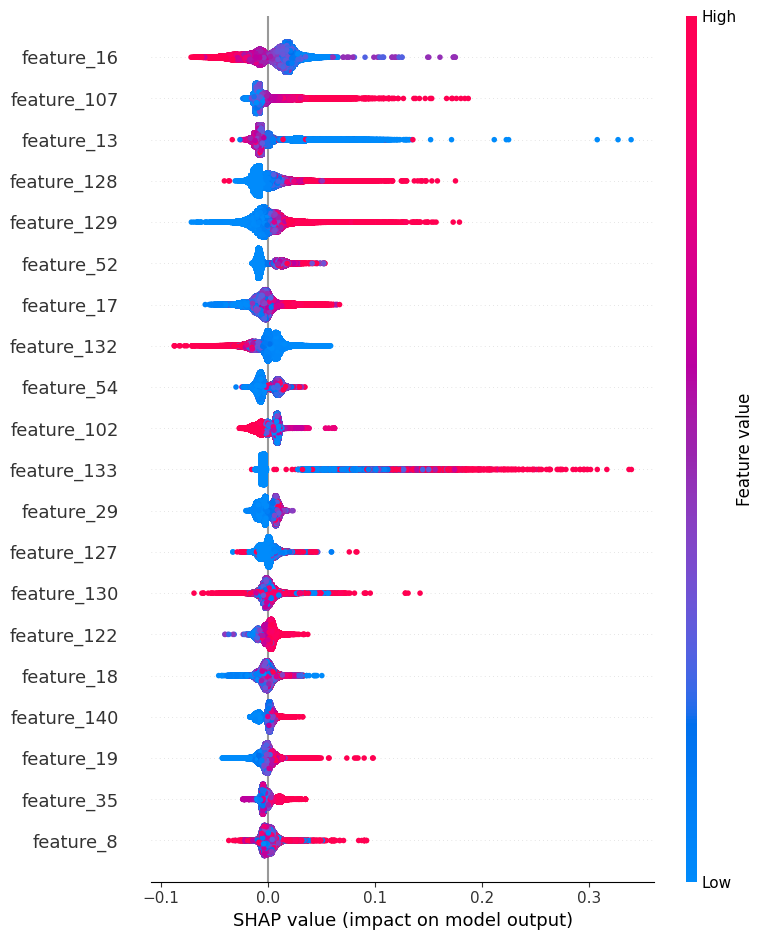

In [47]:
shap.summary_plot(shap_values, X_train)

## Общий вывод

Были получены данные из датасета `intern_task.csv`. 

Для обучения была выбрана модель *CatBoostRanker* и применялись различные параметры: RMSE, Weight+RMSE, QueryRMSE, PairLogit, PairLogitPairwise, YetiRank, YetiRankPairwise.

Получили следующие значения NDCG@5:



| #    | Параметр                | NDCG                                                     |
| ---- | ------------------------| ---------------------------------------------------------|
| 1.   | RMSE                    | 0.99                                                         | 
| 2.   | Weight+RMSE             | 0.99                                                         | 
| 3.   | QueryRMSE               | 0.99                                                         | 
| 4.   | PairLogit               | 0.99                                                         | 
| 5.   | PairLogitPairwise       | 0.87                                                         | 
| 6.   | YetiRank                | 0.99                                                         | 
| 7.   | YetiRankPairwise        | 0.92                                                         | 

Данный расчет предварительный и требует дополнительной проверки, так как, очевидно, модель сильно переобучилась. Возможно ошибка кроется в нахождении финального значения NDCG, так как при обучении были значения в районе 0.6-0.7.
